Dataset  → 6376 images  |  feat-dim = 512
 Best CV 5-fold F1 = 0.903  |  kernel=rbf  C=1

TRAIN metrics
F1    : 0.9577777777777777
Acc   : 0.9552941176470588
Prec  : 0.9631284916201117
Rec   : 0.9524861878453039
ROC-AUC: 0.9895883958596352


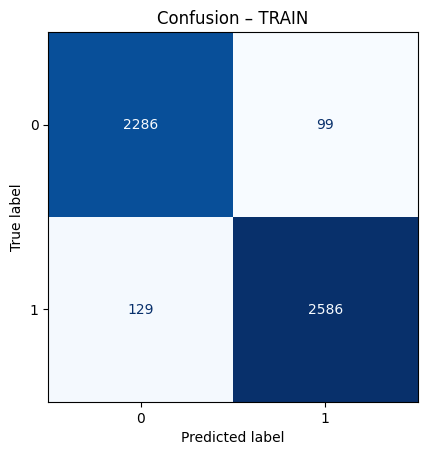

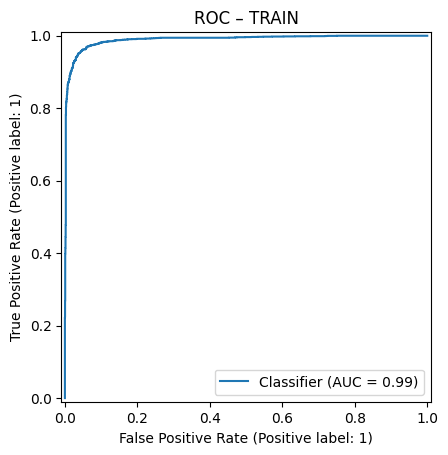


VAL F1: 0.9046563192904656


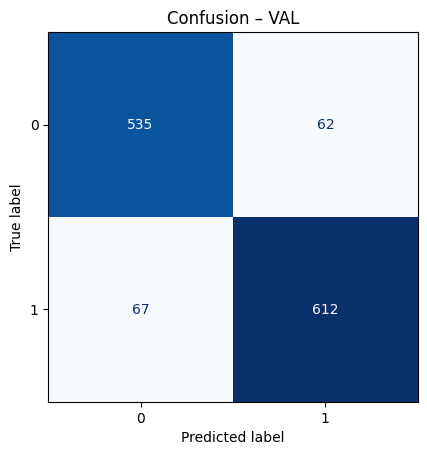

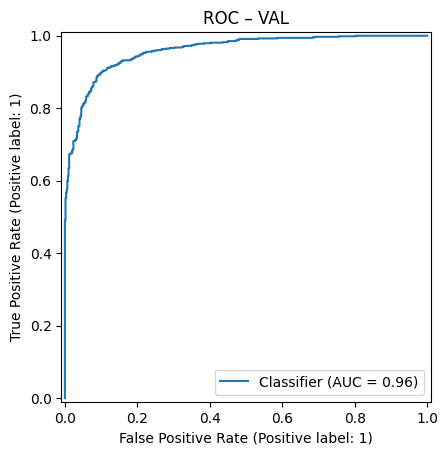


 Saved submission_svm_binary.csv – rows: 500


In [13]:
# ================================================================
#  Pre-trained ResNet18  ➜  SVM (pleasant=1, unpleasant=0)
# ================================================================
import itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch, torchvision.transforms as T, torchvision.models as models

from sklearn.preprocessing   import StandardScaler, Normalizer, LabelEncoder
from sklearn.decomposition   import PCA
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.svm             import LinearSVC, SVC
from sklearn.metrics         import (f1_score, accuracy_score, precision_score,
                                     recall_score, roc_auc_score,
                                     ConfusionMatrixDisplay, RocCurveDisplay)

# ------------------- 0. Paths & Device -------------------------
# Define paths to training images, test images, and ID CSV
train_dir    = Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\train-images\train")
test_img_dir = Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\TEST_images\TEST_images")
ids_csv      = Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\Test-IDs.csv")

# Select GPU if available, otherwise use CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- 1. ResNet‑18 feature extractor ----------------
# Load pretrained ResNet-18 and remove final classification layer
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
feat_extractor = torch.nn.Sequential(*(list(resnet.children())[:-1]))
feat_extractor.eval().to(DEVICE)

# Define image transforms: resize, normalize, convert to 3 channels
img_tf = T.Compose([
    T.Resize((224, 224)),                 # Resize to 224x224 as expected by ResNet
    T.ToTensor(),                         # Convert PIL image to tensor [0,1]
    T.Lambda(lambda x: x.repeat(3, 1, 1)),# Repeat grayscale channel to create 3 channels
    T.Normalize([0.485, 0.456, 0.406],    # Normalize using ImageNet means
                [0.229, 0.224, 0.225])    # and standard deviations
])

@torch.no_grad()
def img2feat(p: Path) -> np.ndarray:
    """
    Load image, apply transforms, extract 512-dim features with ResNet-18
    """
    img = Image.open(p).convert("L")           # Open image in grayscale
    x = img_tf(img).unsqueeze(0).to(DEVICE)      # Add batch dimension and move to DEVICE
    feats = feat_extractor(x)                    # Extract features
    return feats.squeeze().cpu().numpy()         # Remove extra dims and convert to NumPy

# ---------------- 2. Load features & labels -----------------
# Map class names to integer labels
label_map = {"unpleasant": 0, "pleasant": 1}
X, y = [], []
# Iterate over classes in fixed order to maintain label mapping
for cls in ("unpleasant", "pleasant"):     
    for img in (train_dir/cls).iterdir():         # Extract and collect features
        X.append(img2feat(img)); y.append(label_map[cls])      # Append corresponding label

# Stack feature vectors into array and convert types
X = np.vstack(X).astype("float32")            # Shape: (n_samples, 512)
y = np.array(y,  dtype="int8")                # Shape: (n_samples,)

print(f"Dataset  → {X.shape[0]} images  |  feat-dim = {X.shape[1]}")

# ----------- 3. Train / Validation split ------------------------
# Split data into 80% train and 20% validation with stratification
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42)

# ------------------- 4. Scale & PCA ----------------------------
# Fit StandardScaler on train set and transform both train and val
scaler = StandardScaler().fit(X_tr)
X_tr    = scaler.transform(X_tr)
X_val   = scaler.transform(X_val)

# Apply PCA to reduce dimension to 40 with whitening for decorrelation
pca = PCA(n_components=40, whiten=True, random_state=42).fit(X_tr)
X_tr  = pca.transform(X_tr)
X_val = pca.transform(X_val)

# ------------------- 5. Grid-search SVM ------------------------
# Define hyperparameter grids
kernels = ["linear","cosine","rbf"]
Cs      = [0.1, 1, 10, 100]
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1, best_cfg, best_model = 0, None, None
# Loop over all combinations of kernel and C
for ker, C in itertools.product(kernels, Cs):
    if ker == "linear":
        model = LinearSVC(C=C, dual=False, max_iter=5000)
    elif ker == "cosine":
        # Pipeline: normalize then LinearSVC for cosine distance
        model = Pipeline([
            ("norm", Normalizer()), 
            ("svc",  LinearSVC(C=C, dual=False, max_iter=5000))
        ])
    else:  # rbf kernel
        model = SVC(kernel="rbf", C=C, gamma="scale", probability=True)

    # Cross-validated predictions on training set
    y_cv = cross_val_predict(model, X_tr, y_tr, cv=cv, method="predict")
    f1   = f1_score(y_tr, y_cv)
    # Update best model if F1 improves
    if f1 > best_f1:
        best_f1, best_cfg, best_model = f1, (ker,C), model

print(f" Best CV 5-fold F1 = {best_f1:.3f}  |  kernel={best_cfg[0]}  C={best_cfg[1]}")

# ------------------- 6. Train final model ----------------------
# Fit the best model on the entire training set
best_model.fit(X_tr, y_tr)

# ------------------- 7. TRAIN & VAL metrics --------------------
# Helper to get class probabilities
def get_probs(m, X):
    if hasattr(m, "predict_proba"):
        return m.predict_proba(X)[:,1]       # Probability for class=1
    # για LinearSVC
    from scipy.special import expit
    # Convert decision scores to probabilities for LinearSVC
    return expit(m.decision_function(X))

# Predictions & probabilities for train and validation
train_pred = best_model.predict(X_tr)
train_prob = get_probs(best_model, X_tr)
val_pred   = best_model.predict(X_val)
val_prob   = get_probs(best_model, X_val)

# Print training metrics
print("\nTRAIN metrics")
print("F1    :", f1_score(y_tr, train_pred))
print("Acc   :", accuracy_score(y_tr, train_pred))
print("Prec  :", precision_score(y_tr, train_pred))
print("Rec   :", recall_score(y_tr, train_pred))
print("ROC-AUC:", roc_auc_score(y_tr, train_prob))

# Plot confusion matrix and ROC curve for train
ConfusionMatrixDisplay.from_predictions(y_tr, train_pred, cmap="Blues", colorbar=False)
plt.title("Confusion – TRAIN"); plt.show()
RocCurveDisplay.from_predictions(y_tr, train_prob)
plt.title("ROC – TRAIN"); plt.show()

# Print and plot validation F1, confusion matrix, ROC
print("\nVAL F1:", f1_score(y_val, val_pred))
ConfusionMatrixDisplay.from_predictions(y_val, val_pred, cmap="Blues", colorbar=False)
plt.title("Confusion – VAL"); plt.show()
RocCurveDisplay.from_predictions(y_val, val_prob)
plt.title("ROC – VAL"); plt.show()

# ------------------- 8. TEST → hard-label submission -----------
# Read test IDs
ids_df = pd.read_csv(ids_csv)

# Extract the raw 512-d features from ResNet
raw_test_feats = np.vstack([
    img2feat(test_img_dir / fn)
    for fn in ids_df["Filename"]
])  # shape = (n_test, 512)

# Apply the same StandardScaler you fit on X_tr
scaled_test_feats = scaler.transform(raw_test_feats)  # still 512 dims

# Then apply the same PCA you fit on X_tr
test_feats = pca.transform(scaled_test_feats)         # now 40 dims

# Get predicted probabilities for class=1 (“pleasant”)
test_prob = get_probs(best_model, test_feats)

# Threshold to hard labels 
thr = 0.5
test_lbl = (test_prob >= thr).astype(int)

# Build submission DataFrame and save
submission = pd.DataFrame({
    "ID":    ids_df["ID"],
    "LABEL": test_lbl
})
submission.to_csv("submission_svm_binary.csv", index=False)
print(f"\n Saved submission_svm_binary.csv – rows: {len(submission)}")


